# Unbalanced data classification techniques
**Jan Chudy**  
Overview of **techniques for unbalanced data classification** used to date and their comparison.

The main objective of this notebook is to show and compare some of the techniques used for classification on unbalanced datasets. Most of these techniques are resampling strategies which are modifying the dataset in order to help our model classify the minority class (which is in most of the cases the most important one).

References:  
- [1] Porto Seguro’s Safe Driver Prediction on Kaggle: https://www.kaggle.com/c/porto-seguro-safe-driver-prediction
- [2] T. Fawcett - Learning from Imbalanced Classes: https://www.svds.com/learning-imbalanced-classes/
- [X] R. Alencar - Resampling strategies for imbalanced datasets: https://www.kaggle.com/rafjaa/resampling-strategies-for-imbalanced-datasets

### Importing libraries

Here are **all the libraries** we will need. Let's start with the basic ones:

In [1]:
import numpy as np # advanced math functionalities
import pandas as pd # powerful data structures for data analysis
import matplotlib.pyplot as plt # a numerical plotting library
import seaborn as sns # library for plotting and styling

# import warnings

Configuring some options:

In [2]:
pd.set_option('display.max_columns', 60) # forces pandas to displat 60 columns at a time

# configure seaborn to our liking
sns.set_style('darkgrid', {"axes.facecolor": ".95", "axes.edgecolor": "black", \
                           "xtick.bottom": "True", "ytick.left": "True"})
sns.set_context("notebook")
sns.set_palette(["#28abe3", "#db3340", "#e8b71a", "#1fda9a", "#f7eac8"])
blend_palette = sns.diverging_palette(258, 12, sep=20, as_cmap=True)

# plots within notebook versus launching a separate window
%matplotlib inline

# warnings.filterwarnings('ignore')

And some specific libraries and utilities like models, metrics and other algorithms. We will import everything here, nevertheless, I will also add a commented import in every example as needed (in order for you to know which includes are needed for that specific example/model).

In [3]:
from sklearn.linear_model import LogisticRegression # Logistic Regression classifier

from sklearn.model_selection import train_test_split # for splitting dataset into train and test portions
from sklearn.metrics import accuracy_score # accuracy metric
from sklearn.metrics import confusion_matrix # confusion_matrix

## Unbalanced Data

Unbalanced data (or class imbalance) typically refers to a machine learning classification problem where the classes do not make up equal portions of your dataset (Class A - 2%/Class B - 98% of the dataset). Having unbalanced data is very common in general and in practice, you can come across extremely unbalanced data.

**Examples <sup>[2]</sup>:**
- About 2% of credit card accounts are defrauded per year.
- Medical screening for a condition is usually performed on a large population of people without the condition, to detect a small minority with it (e.g., HIV prevalence in the USA is ~0.4%).
- Disk drive failures are approximately ~1% per year.
- The conversion rates of online ads has been estimated to lie between 10<sup>-3</sup> to 10<sup>-6</sup>.
- Factory production defect rates typically run about 0.1%.

### Our Dataset

The dataset we are going to use for our testing is from the [Porto Seguro’s Safe Driver Prediction competition on Kaggle](https://www.kaggle.com/c/porto-seguro-safe-driver-prediction/). The objective of this dataset is to predict the probability that a driver files a claim in the next year (classification problem).

**Data Description <sup>[1]</sup>:**
In the train and test data, features that belong to similar groupings are tagged as such in the feature names (e.g., <code>ind</code>, <code>reg</code>, <code>car</code>, <code>calc</code>). In addition, feature names include the postfix <code>bin</code> to indicate binary features and <code>cat</code> to indicate categorical features. Features without these designations are either continuous or ordinal. Values of <code>-1</code> indicate that the feature was missing from the observation. The <code>target</code> columns signifies whether or not a claim was filed for that policy holder.

We can load the dataset and take a peek at its columns and values.

In [4]:
# read data into pandas
df = pd.read_csv('data/train.csv')

In [5]:
# display first 5 rows of the dataset
df.head()

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_14,ps_ind_15,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_01_cat,ps_car_02_cat,ps_car_03_cat,ps_car_04_cat,ps_car_05_cat,ps_car_06_cat,ps_car_07_cat,ps_car_08_cat,ps_car_09_cat,ps_car_10_cat,ps_car_11_cat,ps_car_11,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,7,0,2,2,5,1,0,0,1,0,0,0,0,0,0,0,11,0,1,0,0.7,0.2,0.718070,10,1,-1,0,1,4,1,0,0,1,12,2,0.400000,0.883679,0.370810,3.605551,0.6,0.5,0.2,3,1,10,1,10,1,5,9,1,5,8,0,1,1,0,0,1
1,9,0,1,1,7,0,0,0,0,1,0,0,0,0,0,0,3,0,0,1,0.8,0.4,0.766078,11,1,-1,0,-1,11,1,1,2,1,19,3,0.316228,0.618817,0.388716,2.449490,0.3,0.1,0.3,2,1,9,5,8,1,7,3,1,1,9,0,1,1,0,1,0
2,13,0,5,4,9,1,0,0,0,1,0,0,0,0,0,0,12,1,0,0,0.0,0.0,-1.000000,7,1,-1,0,-1,14,1,1,2,1,60,1,0.316228,0.641586,0.347275,3.316625,0.5,0.7,0.1,2,2,9,1,8,2,7,4,2,7,7,0,1,1,0,1,0
3,16,0,0,1,2,0,0,1,0,0,0,0,0,0,0,0,8,1,0,0,0.9,0.2,0.580948,7,1,0,0,1,11,1,1,3,1,104,1,0.374166,0.542949,0.294958,2.000000,0.6,0.9,0.1,2,4,7,1,8,4,2,2,2,4,9,0,0,0,0,0,0
4,17,0,0,2,0,1,0,1,0,0,0,0,0,0,0,0,9,1,0,0,0.7,0.6,0.840759,11,1,-1,0,-1,14,1,1,2,1,82,3,0.316070,0.565832,0.365103,2.000000,0.4,0.6,0.0,2,2,6,3,10,2,12,3,1,1,3,0,0,0,1,1,0


The thing we are interested in, however, is how unbalanced the dataset is.

Unique values:  [0 1]
Class_0: 573518
Class_1: 21694
True target values (Class_1) takes 3.64% of the data.
Proportion Class_0 to Class_1: 26.44 to 1


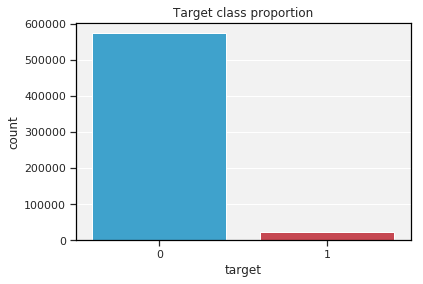

In [6]:
# check uniqie values
target = df.target
print("Unique values: ", target.unique())

# count rows with these values and compute proportion
target_val_cnt = target.value_counts()
print("Class_0:", target_val_cnt[0])
print("Class_1:", target_val_cnt[1])
print("True target values (Class_1) takes {:0.2f}% of the data.".format(target_val_cnt[1]/len(target)*100))
print("Proportion Class_0 to Class_1: {:0.2f} to 1".format(target_val_cnt[0] / target_val_cnt[1]))

# graphical representation of the proportion
sns.barplot(x=target.unique(),y=target_val_cnt)
plt.xlabel("target")
plt.ylabel("count");
plt.title("Target class proportion");

## Why is unbalanced data a problem

With unbalanced dataset, machine learning algorithms are often biased towards the majority class. Loss functions of traditional algorithms attempt to optimize the accuracy, which is not taking the data distribution into consideration. In unbalanced datasets, accuracy is only reflecting the distribution of the majority class. This is also called the **Accuracy Paradox**. In the most extreme cases, minority target values might be treated as outliers of the majority class.

What the model ends up doing in order to optimize the error rate is simply to predict the majority class for every instance (the more unbalanced the dataset). That will give us very high accuracy, which satisfies the model and is a completely correct solution. However, not for our problem, because (most likely) we are trying to correctly predict as much of the minority instances as possible (if a patient got a disease, we want to predict it).

Therefore, accuracy is not the right metric to tell us how good is our model doing. A better metric for us to use would be **recall** (percent of positive instances that were classified as positive). However, there are more metrics for our consideration.

Let's try this on our dataset. We'll train a model and compute its accuracy:

In [7]:
# from sklearn.linear_model import LogisticRegression
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import accuracy_score

# drop target and id columns
X = df[df.columns[2:]]

# devide data into training and testing portion
X_train, X_test, y_train, y_test = train_test_split(X, target, test_size=0.2, random_state=1)

# train the model and predict classes for testing portion
LogReg = LogisticRegression(solver='liblinear')
LogReg.fit(X_train, y_train)
y_pred = LogReg.predict(X_test)

# compute accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: {:0.2f}%".format(accuracy * 100.0))

Accuracy: 96.36%


As we can see, the trained model has very high accuracy. We could almost assume, that the model haven't even try to label any instance as a minority class. 

To find out how well our model really did, we would like to see how instances got misclassified (how many Class_1 targets and Class_0 targets did it miss). Of course, we could compute these values easily, but more interesting and helpful way to evaluate this is **Confusion matrix** (especially, when there are more than two target values).

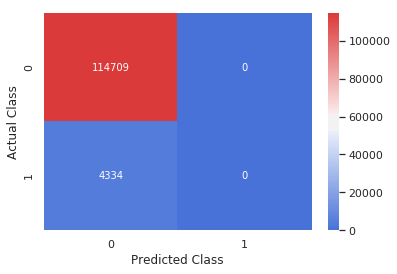

In [8]:
# from sklearn.metrics import confusion_matrix 

# compute the Confusion matrix
conf_mat = confusion_matrix(y_true=y_test, y_pred=y_pred)

# plot a graphical representation of confusion matrix
with sns.axes_style({'xtick.bottom': False, 'ytick.left': False}):
    sns.heatmap(conf_mat, annot=True, fmt="d", cmap=blend_palette)
plt.xlabel('Predicted Class')
plt.ylabel('Actual Class');

In other words, our model failed miserably solving our problem, because it hasn't classified a single Class_1 instance correctly. As we can see from the confusion matrix, it hasn't even tried to.

## How can we combat this problem?

There are many approaches to this problem. Some of them are manipulating the data you have and some of them the algorithm you use. We will discuss these approaches and try out some of them. Here's an overview:

- **Change performance metric**
    - ROC curves & AUC
    - F1 score
    - Cohen’s kappa
- **Cost function sensitivity**
- **Resampling**
    - **Trivial:**
        - Getting more data
        - Random Undersampling
        - Random Oversampling
    - **Advanced:**
        - SMOTE
        - ROSE
        - Tomek Links
    - **Specific:**
        - EasyEnsemble
        - BalanceCascade
        - RUSBoost
        - SMOTEBagging
        - Underbagging
        - Blagging (Balanced bagging)
        - Box Drawings
- **Different Perspective**
    - Anomaly detection
    - Change detection

While dealing with unbalanced data, you will be trying to come up with the right combination (subset) of these approaches to solve your particular problem.

### Change performance metric
As we have shown earlier, accuracy is not the way to go in terms of model's performance evaluation. There are different performance metric for us to see (or tell our model) how well it is performing. Some of them are more comprehensive than others.

We've already used the **Confusion matrix**, which is a very helpful way to see what was classified correctly and what was misclassified. It is also an important reference for some other performance metrics, so let's have a look what is the Confusion matrix showing us.

| Actual / Predicted |    Negative    |    Positive    |
|:------------------:|:--------------:|:--------------:|
|      **Negative**      |  True Negative | False Positive |
|      **Positive**      | False Negative |  True Positive |

<span style="font-size:0.8em">Note: This concept is not limited for binary classification. Right now, we are assuming we have a Positive and a Negative class. You might find Confusion matrixes with a different order of rows/columns.</span>

Just for completeness, **Accuracy** is the number all correctly classified instances divided by the total number of instances (<code>(TP + TN) / Total</code>). And we can already tell, why this is not suitable for us.

Much better metrics (but still very basic) are the Recall and the Precision. We are usually trying to find the right balance between these two, and in most cases (when the minority class is more important to detect), we are more concerned about the recall.  
The **recall** (also Sensitivity or True Positive Rate) is the number of True Positives divided by the number of all positive instances (<code>TP / (TP + FN)</code>). Low recall value indicates a high rate of False Negatives.  
The **precision** (also Positive Predictive Value) is the number of True Positives divided by the number all positive predictions made by our model (<code>TP / (TP + FP)</code>).

Let's have a look at some more advanced metrics which might be more helpful when dealing with unbalanced data.

#### Area Under the ROC curve (AUC)
[TODO]

#### F1 Score
[TODO]

#### Cohen’s kappa
[TODO]

### Cost function sensitivity
Generally, an algorithm presumes, that misclassifying the majority class is identically bad as misclassifying the minority class (as we've demonstrated earlier). We should change the algorithm's perspective on our problem (especially when we are stuck with a specific algorithm we have to use).

#### Penalization

One way to do this is to **penalize our model** for misclassifying a minority class or reward it for classifying it correctly. Either way, our model will pay more attention to minority class instances. To be more precise, it will misclassify more majority instances (giving us more false positives), because it is less costly than misclassifying a minority class instance. This approach is also called **Cost-sensitive learning**.

We can define our own **cost matrix**, which is used to calculate the cost and applied to the classifier (we define the cost of each classification of class A as class B). Setting the right penalization for your problem can be very complex.

#### Adjusting class weights

Adjusting the importance of the minority class is another way to penalize our model because it will directly affect the cost of its errors. In other words, we are balancing the data without changing the distribution of any class.

Many classifiers from Scikit-learn takes an optional parameter <code>class_weight</code>, that can achieve this.

### Resampling

[TODO]

### Different Perspective
[TODO]